# Time Series Pairs Trading Hedge Strategy
_Shivam Pancholi_

***
# 0. Overview

This project implements a mean reversion (pairs trading) strategy focused on the relationship between two major UK energy constituents: Shell (SHEL.L) and BP (BP.L).

The core hypothesis is that while stock prices for individual companies follow a random walk, the linear combination of two companies in the same sector should share a long term integration driven by fundamental economic factors (e.g. oil prices, geopolitical risk).

To capture this relationship, the strategy employs the following quantitative techniques:

*  Log Returns: We utilise natural logarithms to account for scaling differences and model the relationship as a power law.
> __Log Return = ln(P <sub>t</sub>) - ln(P <sub>t-1</sub>)__

*  Z Score Signal Processing: The spread is normalised into a Z Score to identify statistically significant deviations (±2σ) from the mean.


*  Dynamic Hedge Ratio: Instead of a static regression, we calculate a 60-day Rolling Beta to adapt to changing market.
> __Hedge Ratio = Value of Hedge Position / Value of Total Position <br><br>Beta = Covar(R<sub>e</sub>, R<sub>m</sub>) / Var(R<sub>m</sub>)__

* Execution Logic: To maximize profit capture and reduce "noise", the algorithm uses the logic:    
    
    * Enter: When statistical potential energy is high.    
    
    * Hold: As the position levels.     
    
    * Exit: Only when the system returns to equilibrium.

***
## 1. Objectives
The goal is to generate a Market Neutral equity curve that provides positive returns independent of the broader market direction, effectively isolating and extracting a positive alpha from the pairs trading relationship.

***
## 2. Data Preperation

In [1]:
# ==========================================
# DATA INGESTION & PREPARATION
# ==========================================

%pip install -qqq yfinance numpy pandas

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

Note: you may need to restart the kernel to use updated packages.


***
## 3. Statistical Modelling (normalised prices)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


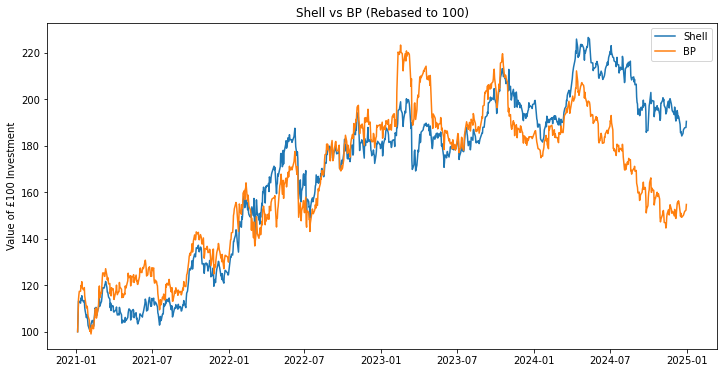

In [2]:
# ==========================================
# STATISTICAL MODELLING (normalised prices)
# ==========================================

# define assets and clean data
start_date = "2021-01-01"
end_date = "2025-01-01"

df_shell = yf.download("SHEL.L", start=start_date, end=end_date, auto_adjust=True)
df_bp = yf.download("BP.L", start=start_date, end=end_date, auto_adjust=True)

close_shell = df_shell['Close']
close_bp = df_bp['Close']

# normalise prices of assets
n_shell = close_shell.copy()
n_bp = close_bp.copy()

for column in n_shell.columns:
    n_shell[column] = (n_shell[column] / float(n_shell.iloc[0])) * 100
    
for column in n_bp.columns:
    n_bp[column] = (n_bp[column] / float(n_bp.iloc[0])) * 100

# plot 1: normalised price of assets  
plt.figure(figsize=(12, 6))
plt.plot(n_shell, label="Shell")
plt.plot(n_bp, label="BP")
plt.title("Shell vs BP (Rebased to 100)")
plt.ylabel("Value of £100 Investment")
plt.legend()
plt.show()

### Analysis

High historical correlation means we can implement a pairs trading strategy. Divergence between stocks should have an elastic relationship with spread being within 2 standard deviations of the mean.

***
## 4. Statistical Modelling (log prices)

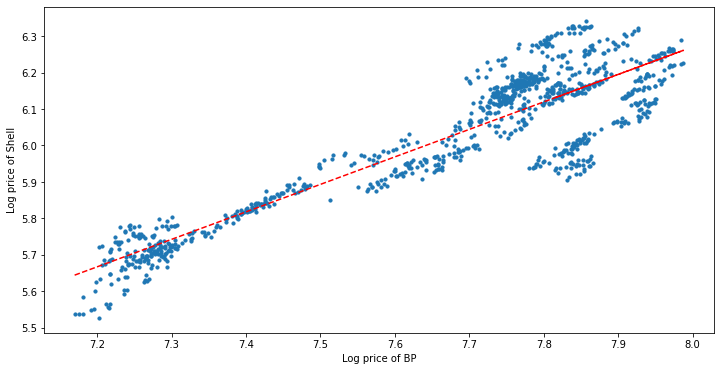

The Hedge Ratio is: 1.0856


In [3]:
# ==========================================
# STATISTICAL MODELLING (Log prices)
# ==========================================

# calculate log prices of assets
log_shell = np.log(close_shell).to_numpy().flatten()
log_bp = np.log(close_bp).to_numpy().flatten()
beta, alpha = np.polyfit(log_bp, log_shell, 1)

# plot 2: comparison between log prices of SHEL.L and BP.L
z = np.polyfit(log_shell, log_bp, 1)
p = np.poly1d(z)

plt.figure(figsize=(12, 6))
plt.xlabel("Log price of BP")
plt.ylabel("Log price of Shell")
plt.scatter(log_shell, log_bp, 10)
plt.plot(log_shell, p(log_shell), "r--")
plt.show()
    
print(f"The Hedge Ratio is: {beta:.4f}")

### Analysis

By plotting log prices of assets, we calculate a gradient for the line of best fit and approximate this to the hedge ratio between SHEL.L and BP.L. We can also apporiximate the hedge ratio to the cross-asset beta. A hedge ratio of 1.0856 suggests SHEL.L is slightly more volatile.

***
## 5. Signal Generation (Z-Score)

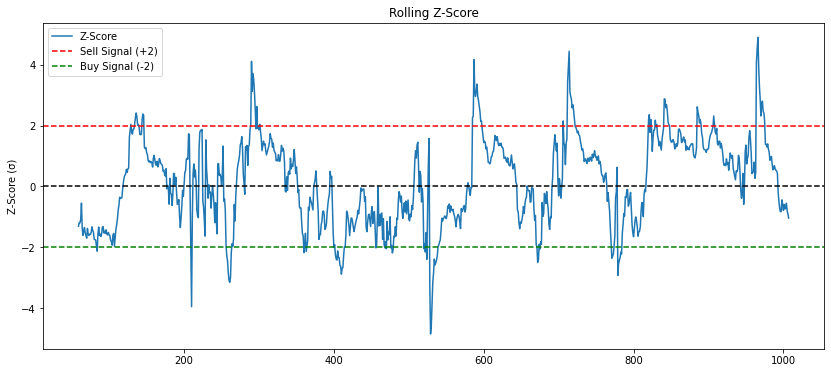

In [4]:
# ==========================================
# SIGNAL GENERATION (Z-SCORE)
# ==========================================

# calculating spread z-score
# we use a 60 day rolling period to smooth out short term price volatility
spread = log_shell - (beta * log_bp + alpha)
rolling_mean = pd.Series(spread).rolling(60).mean()
rolling_std = pd.Series(spread).rolling(60).std()
z_score = (spread - rolling_mean) / rolling_std

# plot 3: rolling z-score
plt.figure(figsize=(14, 6))

plt.plot(z_score, label="Z-Score")
plt.axhline(0, color='black', linestyle='--')
plt.axhline(2.0, color='red', linestyle='--', label="Sell Signal (+2)")
plt.axhline(-2.0, color='green', linestyle='--', label="Buy Signal (-2)")
plt.title("Rolling Z-Score")
plt.ylabel("Z-Score (σ)")
plt.legend()
plt.show()

***
## 6. Back testing strategy

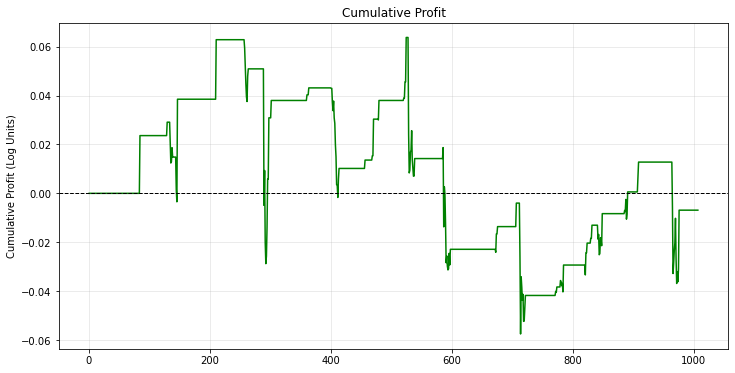

Final Cumulative Profit: -0.0069 units


In [5]:
# ==========================================
# EXECUTION LOGIC (Fixed hedge ratio)
# ==========================================

# setting conditions for back testing
spread_series = pd.Series(spread)
daily_spread_change = spread_series.diff()

conditions = [z_score > 2, z_score < -2]
choices    = [-1, 1]

raw_signal = np.select(conditions, choices, default=0)
signal_series = pd.Series(raw_signal, index=z_score.index)

# shift to simulate price at market close
position = signal_series.shift(1)

daily_profit = position * daily_spread_change

cumulative_profit = daily_profit.cumsum()

# plot 4: cumulative profits with fixed hedge ratio
plt.figure(figsize=(12, 6))
plt.plot(cumulative_profit, color='green')

plt.title("Cumulative Profit")
plt.ylabel("Cumulative Profit (Log Units)")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3)

plt.show()

final_profit = cumulative_profit.iloc[-1]
print(f"Final Cumulative Profit: {final_profit:.4f} units")

### Analysis

With a fixed beta, we do not account for short term changes in the hedge ratio. Implementing our strategy gives us a negative overall profit, therefore the strategy is unsuccessful for a fixed beta.
***

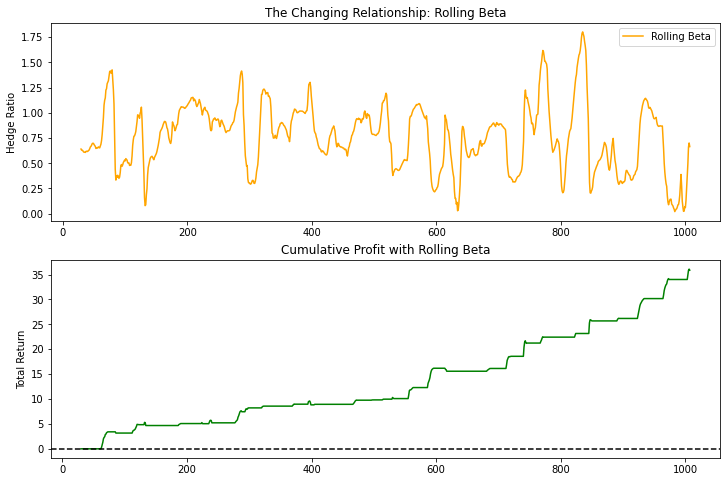

Final Cumulative Profit: 35.8715 units


In [6]:
# ==========================================
# EXECUTION LOGIC (Rolling hedge ratio)
# ==========================================

# calculate rolling beta
Y = pd.Series(log_shell)
X = pd.Series(log_bp)

# we use a 30 day rolling period to smooth out short term price volatility
rolling_cov = Y.rolling(30).cov(X)
rolling_var = X.rolling(30).var()

rolling_beta = rolling_cov / rolling_var

spread = Y - (rolling_beta * X)

rolling_mean = spread.rolling(30).mean()
rolling_std = spread.rolling(30).std()
z_score = (spread - rolling_mean) / rolling_std

# setting conditions for back testing
conditions = [z_score > 2, z_score < -2]
choices    = [1, -1]
signal = np.select(conditions, choices, default=0)
signal_series = pd.Series(signal, index=z_score.index)

# shift to simulate price at market close
position = signal_series.shift(1)
daily_profit = position * spread.diff()

# plot 5: rolling hedge ratio
cumulative_profit = daily_profit.cumsum()

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(rolling_beta, color='orange', label='Rolling Beta')
plt.title("The Changing Relationship: Rolling Beta")
plt.ylabel("Hedge Ratio")
plt.legend()

# plot 6: cumulative profits with rolling hedge ratio
plt.subplot(2, 1, 2)
plt.plot(cumulative_profit, color='green')
plt.title("Cumulative Profit with Rolling Beta")
plt.ylabel("Total Return")
plt.axhline(0, color='black', linestyle='--')
plt.show()

print(f"Final Cumulative Profit: {cumulative_profit.iloc[-1]:.4f} units")

### Analysis

Using a rolling beta gives us a final profit of 35.8716 units which is largely successful. By accounting for short term changed in the hedge ratio, our strategy is now successful.

***
## Conclusion

Overall, the strategy is successful. Through trial of a fixed and rolling beta, the large variation in success between the two cases suggests there is substantial short term volatility which must be accounted for. In addition, the "heart beat" pattern in the rolling z-score suggests an elastic relation between the two assets, which we hypothesised in the anlysis of relation between the normalised prices of the assets.